# Linear Regression

The goal of regression is to predict the value of one or more continuous target variables t given the value of a D-dimensional vector x of input variables, caracterized as supervised problem. Linear regression models are models that try to solve regression problems which share the property of being linear functions of the adjustable parameters,
$$y(\vec{x},\vec{w}) =  w_0 + w_1 x_1 + ... + w_j x_j = w_0 + \sum_{j=1}^{M-1} w_j x_j$$



In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st
import math

## Data

Now consider we have a data set with two variable and we want to predict the value of one of them based in the other. We will use an artificial dataset where given x, y is the sinoidal function in addition to a gaussian noise.

$$y = sin(x) + \epsilon$$

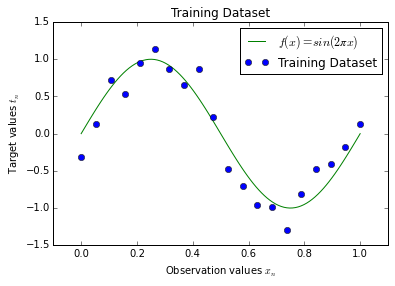

In [2]:
# Dataset parameters
N = 20;

# generate the function that drives the data
C_x = np.linspace(0, 1, num=100);
C_y = np.sin(2*np.pi*C_x); 
plt.plot(C_x,C_y,'-g',label='$f(x) = sin(2πx)$');


# Generate N samples from the sintetic data to be our training set
X = np.linspace(0, 1, num=N);
T = np.sin(2*np.pi*X);
# add gaussian random noise
T = T + np.random.normal(loc=0,scale=0.2,size=T.shape[0]);
T = np.reshape(T,(N,1))
plt.plot(X,T,'ob',label ='Training Dataset');

#configure and show plots
plt.ylim([-1.5, 1.5]);
plt.xlim([-0.1, 1.1]);
plt.ylabel('Target values $t_n$');
plt.xlabel('Observation values $x_n$');
plt.title('Training Dataset');
plt.legend(loc='upper right');
plt.show();



## Linear Basis Functions

Raw Linear Models have huge limitations since it is also linear in relation to the input variables $X = (x_1,..x_n)^t$. In many practical applications, we will apply some form of fixed preprocessing, or feature extraction, to the original data variables. If the original variables comprise the vector x, then the features can be expressed in terms of the **basis functions** $\left( \phi_j(x) \right)$. We therefore extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables, of the form 

$$y(\vec{x},\vec{w}) =  w_0 + \sum_{j=1}^{M-1} w_j \phi_j(x) = W^t \Phi(X)$$

where $W = (w_0,...,w_m)$ are learnt parameters and $\phi_j(x)$ are basis functions. In addition, It is often convenient to define an additional dummy ‘basis function’ $\phi_0(x) = 1$. By using nonlinear basis functions, we allow the function $y(x, w)$ to be a nonlinear function of the input vector $X$. 

There are many possible basis function and which one is better really depends on the problem. Considering the data above, which we know can be approximated by a polynomial, we are gonna use the polynomial basis function for the rest of this tutorial.

* Some Popular Basis Functions: Gaussian Basis function, Sigmoid Basis Function, Polynomial Basis Function, Tangent hyperbolic basis function, Fourier basis, Wavelets.

In [3]:
#polynomial basis function
P = 3
poly_feat = lambda D, P: np.reshape(np.concatenate([np.power(D,p) for p in range(P+1)], axis=0), (D.size, P+1), order='F')
Phi = poly_feat(X,P)

## Maximum likelihood and Least square Error

Now we need a way to learn the parameters $W$ in order to build the function $y(x,W)$ that give us the value of t. There are different approaches to do that, and we are gonna look to the frenquentist approach which states that the paramenters W are given by the Maximum Likelilihood Probability over the training data.

As before, we assume that the target variable t is given by a deterministic function $y(x, w)$ with additive Gaussian noise so that,
$$t = y(x,w) + \epsilon$$
where $\epsilon$ is a zero mean Gaussian random variable with precision (inverse variance) $\beta$. Thus we can write
$$p(t|x,w,\beta) = N(t|y(x,w),\beta)$$
Making the assumption that the training data points are drawn independently , we obtain the following expression for the likelihood function, which is a function of the adjustable parameters w and β, in the form,
$$p(T|X,W,\beta) = \prod^N N(t_n|y(x_n,W),\beta)$$

Taking the logarithm of the likelihood function, and making use of the standard form of the univariate Gaussian, we have
$$ln p(T|X,W,\beta) = \frac{N}{2} ln \beta - \frac{N}{2} ln(2\pi) - \beta \frac{1}{2} \sum^N (t_n - y(x_n,W))^2$$
where the last term is the so called Least Square Error function. **Therefore, maximize the log likelihhod is in fact minimizing the Least square Error**. 

In order to have a more robust model, we introduce the idea of adding a regularization term to an error function in order to control overfitting, so that the total error function to be minimized takes the form,
$$E = \frac{1}{2} \sum^N (t_n - y(x_n,W))^2 + \frac{\lambda}{2}\sum_j^M |w_j|^q$$
where q defines the regularizer and $\lambda$ controls the relative importance of the data-dependent regularization term, for instance q = 2 corresponds to the quadratic regularizer. Regularization allows complex models to be trained on data sets of limited size without severe overfitting, essentially by limiting the effective model complexity. In this tutorial we are gonna use the quadratic regularizer.


There are two basic ways to proceed from now: solve in one step with closed form or solve sequentially with gradient descent approach.

### Closed form solution (Normal Equations)

This technique involves processing the entire training set in one go, it can be computationally costly for large data sets. Thus, if the training data set fits in memory we can use this solution that is more stable, but for large data set we should use the sequential approach.  

From the log likelihood we can substitute function $y(W,x_n)$ by $W^T \Phi_n$, taking the gradient from the squared error, setting the gradient to zero, and solving for the parameters W, **we get the closed form solution to the least square error also known as Normal Equations**.

$$W_{ml} = (\lambda I + \Phi^T \Phi)^{-1} \Phi^T T$$

$$\Phi = \begin{bmatrix}
    \phi_0(X_1)& \phi_1(X_1) & \dots & \phi_{M-1}(X_1) \\
    \phi_0(X_2) & \phi_1(X_2) & \dots & \phi_{M-1}(X_2) \\
    \dots      & \dots & \dots &  \dots\\
    \phi_0(X_n) & \phi_1(X_n) & \dots & \phi_{M-1}(X_n)
\end{bmatrix}$$

Once we have the $W_{ml}$ parameters we can again set the gradient of the squared error to zero and solve to the parameter $\beta$, which end up,

$$\frac{1}{\beta_{ml}} = \frac{1}{N} \sum^N (t_n - W_{ml}^T\phi(x_n))^2 $$


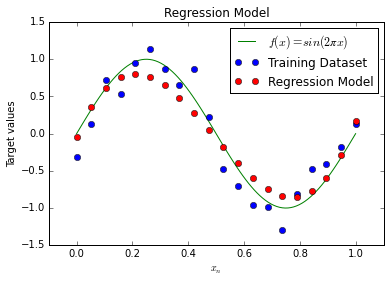

In [4]:
#Solving by Normal equations
lamb = 0.001
W_ml = np.dot(np.linalg.pinv( (lamb * np.identity(P+1)) + np.dot(np.transpose(Phi), Phi)), np.dot(np.transpose(Phi), T))

#predict labels for the training set with the mode y(X, W)
Y = np.dot(Phi, W_ml)


#plot
plt.plot(C_x,C_y,'-g',label='$f(x) = sin(2πx)$')
plt.plot(X,T,'ob',label ='Training Dataset')
plt.plot(X,Y, 'or', label='Regression Model')
plt.ylim([-1.5, 1.5]);
plt.xlim([-0.1, 1.1]);
plt.ylabel('Target values');
plt.xlabel('$x_n$');
plt.title('Regression Model');
plt.legend(loc='upper right');
plt.show();


### Sequential Solution (LMS)

This algorithm is more suitable for large data sets since it processes batches of the data iteractivelly. Sequential learning is also appropriate for realtime applications in which the data observations are arriving in a continuous stream, and predictions must be made before all of the data points are seen.

We can obtain a sequential learning algorithm by applying the technique of stochastic gradient descent, also known as sequential gradient descent, as follows. If the error function comprises a sum over data points $E = \sum_n E_n$ , then after presentation of pattern n, the sthocastic gradient descent algorithm updates the parameter vector w using,

$$W^{(\tau+1)} = W^{(\tau)} - \alpha \nabla E_n  $$

where $\tau$ denotes the iteration number, and $\alpha$ is a learning rate parameter. The value of w is initialized to a zeros starting vector $w^{(0)}$. For the case of the sum-of-squares error function, this gives

$$W^{(\tau+1)} = W^{(\tau)} - \alpha (t_n - W^{(\tau)T} \phi_n) \phi_n + \lambda W $$

The value of $\alpha$ should be chosen with care to ensure the algorithm converges. It can not be too high in order to avoid overshot and can not bee to small in order to avoid really small movements towards the minimum. In each iteration the gradient descent minimizes the squared error and update the parameters W. **Note in the regularization term the $W_0 = 0$ since it is independent of X**.

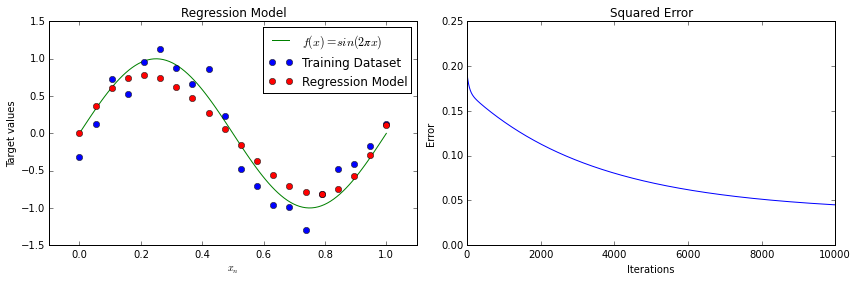

In [5]:
# LMS parameters
alpha = 1; lamb= 0.0001; batch_size = 5; epoch = 10000;

# init w 
W_sq = np.zeros((1,P+1))

#shuffle data set
ind = np.random.permutation(N); X = X.take(ind, axis=0); T = T.take(ind, axis=0); Phi = Phi.take(ind, axis=0);

#sequential learning - gradient descent
error_hist = np.zeros((epoch,1))
for e in range(epoch):
    for b in range(0, N+1, batch_size):
        #get batch
        ind = range(b, min(b+batch_size, N));         
        Phi_b = Phi.take(ind, axis=0); T_b = T.take(ind, axis=0); 
        
        #compute the derivative 
        delta = (1.0/N) * (np.dot(np.transpose((np.dot(Phi_b, np.transpose(W_sq)) - T_b)), Phi_b) \
                + (lamb * np.concatenate((np.zeros((1,1)),W_sq[:,1:]), axis=1)))

        #update parameters
        W_sq = W_sq - (alpha * delta)
    
    #compute sqared error 
    error_hist[e,0] =  (1.0/(2*N))*(np.sum(np.power(T - np.dot(Phi, np.transpose(W_sq)), 2)) \
                        + lamb * np.dot(W_sq,np.transpose(W_sq)))
#predict labels for the training set with the mode y(X, W)
Y = np.dot(Phi, np.transpose(W_sq))

#plot training data
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);
plt.plot(C_x,C_y,'-g',label='$f(x) = sin(2πx)$')
plt.plot(X,T,'ob',label ='Training Dataset')

#plot model prediction
plt.plot(X,Y, 'or', label='Regression Model')
plt.ylim([-1.5, 1.5]);
plt.xlim([-0.1, 1.1]);
plt.ylabel('Target values');
plt.xlabel('$x_n$');
plt.title('Regression Model');
plt.legend(loc='upper right');

#plot error
plt.subplot(1,2,2);
plt.plot(error_hist)
plt.ylabel('Error');
plt.xlabel('Iterations');
plt.title('Squared Error');

plt.tight_layout()
plt.show();


### Observations
1. Geometrical interpretation of the least-squares solution, in an N -dimensional space whose axes are the values of $t_1 , . . . , t_N$ . The least-squares regression function is obtained by finding the orthogonal projection of the data vector t onto the subspace spanned by the basis functions $\phi_j(x)$ in which each basis function is viewed as a vector $\phi_j$ of length N with elements $\phi_j(x_n)$.
2. Bias term $w_0$: the bias $w_0$ compensates for the difference between the averages (over the training set) of the target values and the weighted sum of the averages of the basis function values.
3. Multiple outputs ts: This could be done by introducing a different set of basis functions for each component of t (or the same set for each component t), leading to **multiple, independent regression problems (more than one W)**.
$$T_{KxN} = W_{MxK}^T \Phi(X)_{MxN}$$



## Things to Play:

1. Change the data set size
2. Change the polynomial order of the basis function
3. Play with different weights for the l2-regularization
4. (Sequential Learning) Play with learning rate and weight decay


# Bayesian Linear Regression

This tutorial turn to a Bayesian treatment of linear regression, which will avoid the over-fitting problem of maximum likelihood, and which will also lead to automatic methods of determining model complexity using the training data alone.


## Learning

In bayesian treatment, we do not estimate parameters explicitly, we use probabilty framework to model our uncertainity about the parameters. Thus, we define a prior distribution over the parameters, a likelihood function and compute the posteriori ditribution. In order to make the computation easier we choose a prior conjugate. Therefore, our posteriori is just the prior updated by the likelihood of the data observed.

For simplicity, let's consider the prior over w as a gaussian with mean zero and covariance $\alpha^-1 I$,
$$p(w|\alpha) = N(w|0,\alpha^{-1} I)$$

The corresponding posteriori distribution is,
$$P(W|D,\alpha) = P(D|W,\alpha) P(W|\alpha) = N(M_n,S_n)$$

where $M_n$ and $S_n$ are,
$$M_n = \beta S_n \Phi^T T$$
$$S_n = \alpha I + \beta \Phi^T \Phi$$

As you can see, the maximum posterior weight vector $w$ is simply given by $w_{MAP} = m_N$ .If we consider an infinitely broad prior $S_0 = \alpha^{-1} I$ with α → 0, the mean $m_N$ of the posterior distribution reduces to the maximum likelihood value $w_ML$. Similarly, if $N = 0$, then the posterior distribution reverts to the prior. Furthermore, if data points arrive sequentially, then the posterior distribution at any stage acts as the prior distribution for the subsequent data point, such that the new posterior distribution. 

In addition, **Maximization of this posterior distribution with respect to w is therefore equivalent to the minimization of the sum-of-squares error function with the addition of a quadratic regularization term.**

In summary, we can repeat the bayesian treatment with any distribution to be the prior and likelihood using the conjugancy property.

In [6]:
#parameters
alpha = 0.1; beta = 0.01;

#Define posteriori that is equal to prior when no data is obeserved since the conjugance property
M_n = np.zeros((P+1)); S_n = (1.0/alpha)*np.identity(P+1);
postW = lambda W, M_n, S_n : st.multivariate_normal.pdf(W, mean=M_n, cov=S_n)

#update posteriori parameters according to likelihood of the data

M_n = np.dot(np.linalg.pinv(np.dot(np.transpose(Phi), Phi) \
    + (beta * alpha * np.identity(P+1))), np.dot(np.transpose(Phi),T))
S_n = beta * np.linalg.pinv(np.dot(np.transpose(Phi), Phi) \
    + (beta * alpha * np.identity(P+1)))

## Inference

In practice, we are not usually interested in the value of w itself but rather in making predictions of t for new values of x. In a simplest bayesian approach we can denote the parameter w of the linear model equal to the maximum a posteriori distributions, $y(w,x) = y(W_{map}, x)$ which end up with the linear regression model with maximum likelihood estimation with a quadratic regularizer.

However,we can also evaluate the predictive distribution defined by
$$P(Y|X,T,\alpha,\beta) = N\left(t \mid M_n^T \phi(X), \left(\frac{1}{\beta} + \phi(X)^TS_n\phi(X)\right)\right)$$
The value y predicted is the mean of the distribution created from the parameters learnt $(M_n, S_n)$ and the new evidence $\phi(x)$.

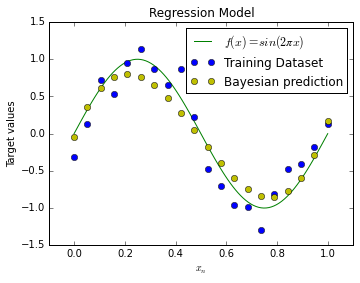

In [7]:
#predict with Map estimation
Y = np.dot(Phi, M_n)

#predict with predictive distribution
predY = lambda X, mean, var : st.norm.stats(loc=np.dot(X,mean), scale=np.sqrt((1.0/beta) + np.dot(X, np.dot(S_n, np.transpose(X)))), moments='m')
pred = np.zeros((N,1))
for idx in range(N):
    pred[idx] =  predY(Phi[idx,:], M_n, S_n)


#plot training data
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);
plt.plot(C_x,C_y,'-g',label='$f(x) = sin(2πx)$')
plt.plot(X,T,'ob',label ='Training Dataset')
plt.plot(X, pred, 'oy', label='Bayesian prediction')
#plot model prediction
#plt.plot(X,Y, 'or', label='Regression Model')
plt.ylim([-1.5, 1.5]);
plt.xlim([-0.1, 1.1]);
plt.ylabel('Target values');
plt.xlabel('$x_n$');
plt.title('Regression Model');
plt.legend(loc='upper right');
